# Classification des images
                                            Emanuela Boros
                                            Université de La Rochelle

# 1. Introduction

La classification des objets consiste à attribuer une classe à un objet. 

<figure>
    <center>
    <img src="images/classification.jpeg" width="400" height="600">
    <figcaption>Source: <a href="https://www.freecodecamp.org/news/chihuahua-or-muffin-my-search-for-the-best-computer-vision-api-cbda4d6b425d/">Link</a></figcaption>
    </center>
</figure>

Dans ce cours, nous explorerons un ensemble de données, une analyse de texte et plusieurs approches basées sur l'apprentissage automatique et profond, de la manière suivante:

- **Récupération** du corpus d'images (*.csv, *.json, etc.)
- **Prétraitement** des images (image pre-processing) : réduction de taille etc
- **Representation** des images (pixels, HOG, SIFT)
- **Apprentissage automatique** (machine learning) et **apprentissage profond** (deep learning)
- **Analyse d'erreurs** (evaluation, etc.)

# 2. Récupération, Prétraitement et Exploration du corpus des images


## 2. 1. Contexte

Le gouvernement américain a attaqué en justice cinq grands groupes américains du tabac pour avoir amassé d'importants bénéfices en mentant sur les dangers de la cigarette. Le cigarettiers  se sont entendus dès 1953, pour "mener ensemble une vaste campagne de relations publiques afin de contrer les preuves de plus en plus manifestes d'un lien entre la consommation de tabac et des maladies graves". 

Dans ce procès 6,910,192 de documents ont été collectés et numérisés. Afin de faciliter l'exploitation de ces documents par les avocats, vous êtes en charge de mettre en place une classification automatique des types de documents: **Advertisement, Email, Form, Letter, Memo, News, Note, Report, Resume, Scientific**.


<table>
  <tr>
    <td>Letter</td>
     <td>News</td>
  </tr>
  <tr>
    <td><img src="images/50661869-1869.jpg" width=270 height=480></td>
    <td><img src="images/10031617.jpg" width=270 height=480></td>
  </tr>
 </table>


Un échantillon aléatoire des documents a été collecté et des opérateurs ont classé les documents dans des répertoires correspondant aux classes de documents : lettres, rapports, notes, email, etc. Vous avez à votre disposition : 

- le chemin de l'image; <ins>**path**</ins>
- les classes des documents définies par des opérateurs; <ins>**label**</ins>

Nous pourrons charger et regarder le structure de ces commentaires avec la bibliothèque pandas (plus d'info [```pandas```](https://pandas.pydata.org/docs/user_guide/index.html)).



In [1]:
import pandas as pd # https://pandas.pydata.org/docs/

data = pd.read_csv('data/Tobacco3482-images/tobacco_images.csv')#.sample(frac=.5) # lire le fichier .csv

In [2]:
len(data)

696

In [3]:
data.head() # afficher les 5 premières lignes

,path,label
0,data/Tobacco3482-images/Scientific/2051025161.jpg,Scientific
1,data/Tobacco3482-images/Note/87705667.jpg,Note
2,data/Tobacco3482-images/Scientific/50590463-04...,Scientific
3,data/Tobacco3482-images/Resume/50617225-7226.jpg,Resume
4,data/Tobacco3482-images/News/2078115137.jpg,News


In [4]:
data.tail() # afficher les 5 dernières lignes

,path,label
691,data/Tobacco3482-images/Note/12882100.jpg,Note
692,data/Tobacco3482-images/Form/2505233645_3646.jpg,Form
693,data/Tobacco3482-images/Memo/2048153405_204815...,Memo
694,data/Tobacco3482-images/Scientific/50492374-23...,Scientific
695,data/Tobacco3482-images/Form/2505106228.jpg,Form


Avec Pandas, nous pouvons commencer avec quelques statistiques simples. Les résultats suivants seront dans l'ordre décroissant de sorte que le premier élément soit l'élément le plus fréquent.

In [5]:
data.label.value_counts()

Memo             127
Email            118
Letter           105
Form              98
Scientific        60
Report            49
News              42
Advertisement     41
Note              36
Resume            20
Name: label, dtype: int64

Avec Pandas, nous pouvons également visualiser ces statistiques.

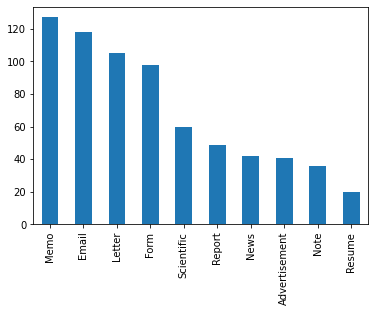

In [6]:
_ = data.label.value_counts().plot(kind='bar')

Nous avons vu que le fichier .csv contenait les chemins et les étiquettes des documents. Maintenant, nous devons lire les fichiers à partir des chemins spécifiés pour obtenir les images.


In [7]:
!pip install opencv-python opencv-contrib-python

In [8]:
import os
import numpy as np
import cv2

images = []
for idx, line in data.iterrows(): # itérer dans un dataframe Pandas
    image = cv2.imread(line['path'])
    images.append(image)
    
data['image'] = images # créer une nouvelle colonne dans le dataframe Pandas avec les textes associés

In [9]:
data.head()

,path,label,image
0,data/Tobacco3482-images/Scientific/2051025161.jpg,Scientific,"[[[242, 242, 242], [255, 255, 255], [251, 251,..."
1,data/Tobacco3482-images/Note/87705667.jpg,Note,"[[[255, 255, 255], [252, 252, 252], [249, 249,..."
2,data/Tobacco3482-images/Scientific/50590463-04...,Scientific,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,data/Tobacco3482-images/Resume/50617225-7226.jpg,Resume,"[[[203, 203, 203], [199, 199, 199], [179, 179,..."
4,data/Tobacco3482-images/News/2078115137.jpg,News,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


## 2.2 Pré-traitement des images 

Comme dans la première partie où nous avons représenté les mots par des vecteurs, nous allons représenter les images par des vecteurs aussi. Comme pour les mots, il y a plusieurs types de représentations pour les images. Chaque représentation peut ajouter des informations supplémentaires sur une image. Plus précisément, certains types de représentations fournissent des informations qui ne sont pas évidentes dans une représentation triviale.

Parmi les représentations existantes, nous allons analyser:
 - RGB
 - Gris
 - HOG

### RGB (Red, Green, Blue)

Rouge, vert, bleu, abrégé en RVB ou en RGB (de l'anglais « red, green, blue ») est un système de codage informatique des couleurs, le plus proche du matériel. Le codage RVB indique une valeur pour chacune de ces couleurs primaires. 

<figure>
    <center>
    <img src="images/sample_image.png" width="400" height="600">
    <figcaption>height, width, channels</figcaption>
    </center>
</figure>

In [10]:
print('height, width, channels', data['image'][0].shape) # shape = height, width, channels

height, width, channels (560, 437, 3)


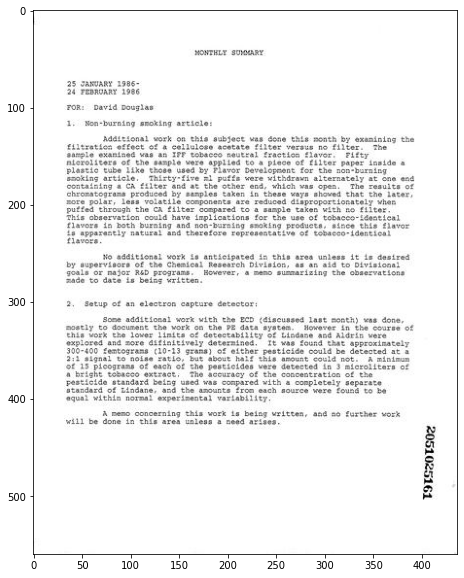

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(data['image'][0])
plt.show()

Puisque nos données sont grises, nous prenons une autre image comme exemple (pour afficher les valeurs RGB):

In [12]:
import cv2
sample_image = cv2.imread('images/apples.jpg', cv2.COLOR_BGR2RGB)

def get_RGB_image(image):
    # converting image to HSV format with cv2.COLOR_BGR2RGB
    sample_rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return sample_rgb_image

sample_image = get_RGB_image(sample_image)

print("Image Properties")
print("Number of Pixels: " + str(sample_image.size))
print("Shape/Dimensions (height, width, channels): " + str(sample_image.shape))

Image Properties
Number of Pixels: 1205604
Shape/Dimensions (height, width, channels): (549, 732, 3)


In [13]:
print("Pixels:", sample_image)

Pixels: [[[220 169 166]
  [221 170 167]
  [221 170 167]
  ...
  [164  46  58]
  [163  45  57]
  [162  45  54]]

 [[222 171 168]
  [222 171 168]
  [222 173 169]
  ...
  [156  45  54]
  [158  44  54]
  [158  44  54]]

 [[221 172 168]
  [222 173 169]
  [221 173 171]
  ...
  [146  40  50]
  [147  41  51]
  [147  41  51]]

 ...

 [[218 170 148]
  [216 169 139]
  [220 171 138]
  ...
  [232 159 144]
  [236 159 143]
  [236 157 140]]

 [[234 187 177]
  [225 180 159]
  [217 176 144]
  ...
  [231 150 133]
  [234 148 131]
  [231 142 124]]

 [[233 188 183]
  [228 187 169]
  [224 187 158]
  ...
  [228 135 118]
  [230 130 115]
  [223 120 105]]]


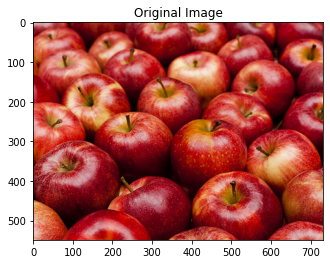

In [14]:
import matplotlib.pyplot as plt

plt.imshow(sample_image)
plt.title('Original Image')
plt.show()

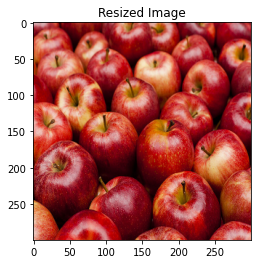

In [15]:
image = cv2.resize(sample_image, (300, 300))

plt.imshow(image)
plt.title('Resized Image')
plt.show()

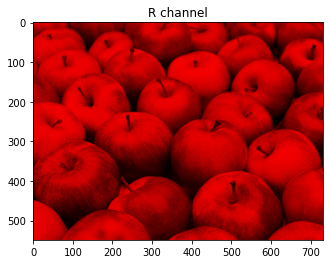

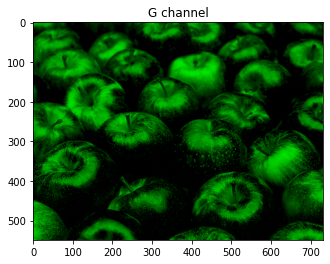

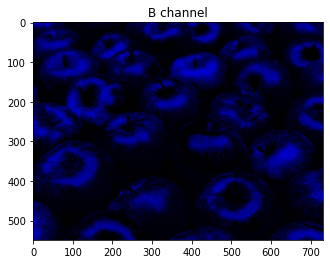

In [16]:
# We separate the image in the 3 channels: red, green and blue
channel_initials = list('RGB')

for channel_index in range(3):
    
    channel = np.zeros(shape=sample_image.shape, dtype='uint8')
    channel[:,:,channel_index] = sample_image[:,:,channel_index]

    plt.imshow(channel)
    plt.title(channel_initials[channel_index] + ' channel')
    plt.show()

### Gris

Une autre possibilité est la représentation de ces images dans les nuances de gris. 

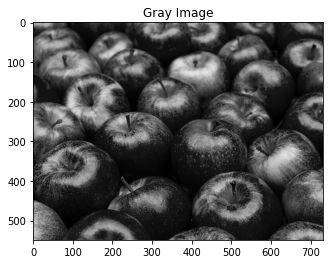

In [17]:
def get_gray_image(image):

    # converting image to HSV format with cv2.COLOR_BGR2GRAY
    sample_gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return sample_gray_image

sample_gray_image = get_gray_image(sample_image)
plt.imshow(sample_gray_image, cmap='gray', vmin=0, vmax=255)
plt.title('Gray Image')
plt.show()

### HSV (hue, saturation, value)

HSV est une représentation alternative du modèle de couleur RGB. La représentation HSV modélise la façon dont les couleurs apparaissent sous la lumière.
Teinte (hue) spécifie l'angle de la couleur sur le cercle de couleur RGB.
La saturation contrôle la quantité de couleur utilisée.
La valeur (value) contrôle la luminosité de la couleur.

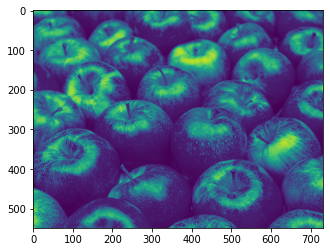

In [18]:
def get_HSV_image(image):
    # converting image to HSV format with cv2.COLOR_BGR2HSV
    sample_hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return sample_hsv_image

sample_hsv_image = get_gray_image(sample_image)
plt.imshow(sample_hsv_image)
plt.show()

In [19]:
print("Pixels:", sample_hsv_image.shape)

Pixels: (549, 732)


Nous pouvons également transformer l'image en **différentes nuances de gris**.

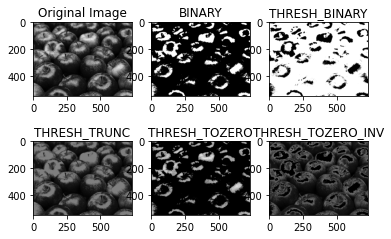

In [20]:
def get_gray_thresh_binary(image):
    _, thresh_binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return thresh_binary

def get_gray_thresh_binary_inv(image):
    _, thresh_binary_inv = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    return thresh_binary_inv
 
def get_gray_thresh_trunc(image):
    _, thresh_trunc = cv2.threshold(image, 127, 255, cv2.THRESH_TRUNC)
    return thresh_trunc
 
def get_gray_thresh_tozero(image):
    _, thresh_tozero = cv2.threshold(image, 127, 255, cv2.THRESH_TOZERO)
    return thresh_tozero
 
def get_gray_thresh_tozero_inv(image):
    _, thresh_tozero_inv = cv2.threshold(image, 127, 255, cv2.THRESH_TOZERO_INV)
    return thresh_tozero_inv

# Displaying the different thresholding styles
 
names = ['Original Image','BINARY','THRESH_BINARY','THRESH_TRUNC','THRESH_TOZERO','THRESH_TOZERO_INV']
 
images = [sample_gray_image, 
          get_gray_thresh_binary(sample_gray_image), 
          get_gray_thresh_binary_inv(sample_gray_image), 
          get_gray_thresh_trunc(sample_gray_image), 
          get_gray_thresh_tozero(sample_gray_image), 
          get_gray_thresh_tozero_inv(sample_gray_image)]

for i in range(6):
 
    plt.subplot(2, 3, i+1), plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
 
    plt.title(names[i])

## 2.3 Répresentation des images 


### Canny Edge Detection (détection de bord Canny) 

- est un algorithme de détection de bord populaire. Il a été développé par John F. Canny en 1986. C'est un algorithme en plusieurs étapes et nous passerons par plusieurs étapes. Deux des plus importants sont: la réduction du bruit (étant donné que la détection des contours est sensible au bruit dans l'image, la première étape consiste à supprimer le bruit dans l'image avec un filtre gaussien 5x5.) Et la recherche du gradient d'intensité de l'image.

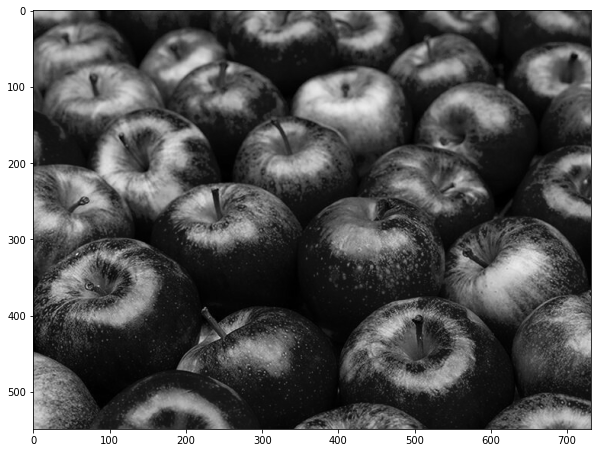

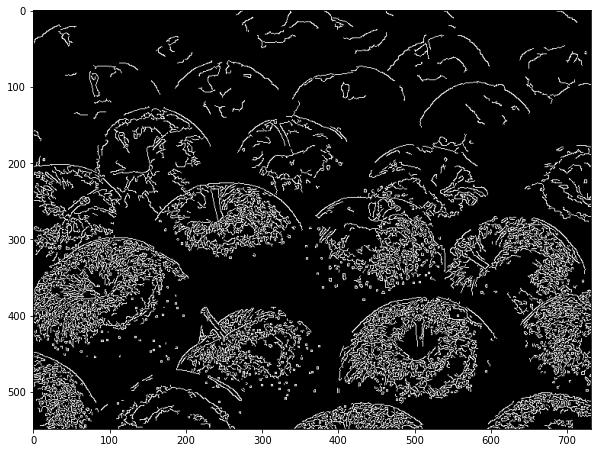

In [21]:
def get_edges(image):
    #calculate the edges using Canny edge algorithm
    edges_of_image = cv2.Canny(sample_gray_image, 100, 200) 
    return edges_of_image

plt.figure(figsize=(10, 10))

plt.imshow(sample_gray_image, cmap='gray')
plt.show()

#plot the edges
edges_of_image = get_edges(image)
plt.figure(figsize=(10, 10))
plt.imshow(edges_of_image, cmap='gray')
plt.show()

### Gaussian blur : réduire le bruit de l'image

Dans le traitement d'image, un flou gaussien (également connu sous le nom de lissage gaussien) est le résultat du flou d'une image par une fonction gaussienne (du nom du mathématicien et scientifique Carl Friedrich Gauss).

C'est un effet largement utilisé généralement pour réduire le bruit de l'image et réduire les détails.

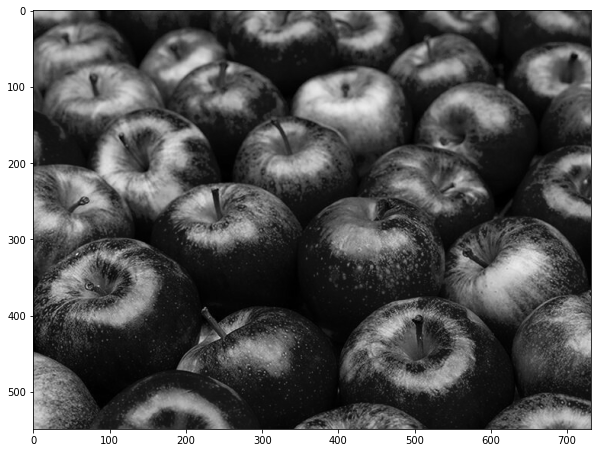

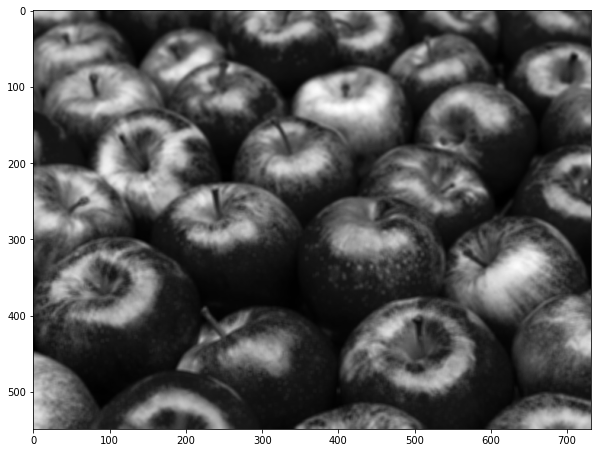

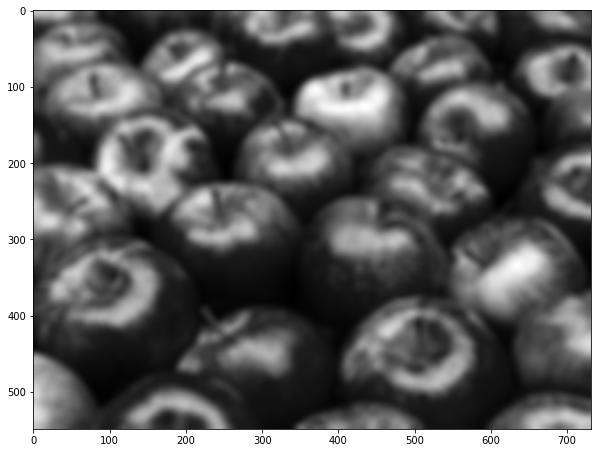

In [22]:
import numpy as np

plt.figure(figsize=(10, 10))
plt.imshow(sample_gray_image, cmap='gray')
plt.show()

def get_smoothen_image(image):
    #using the averaging kernel for image smoothening 
    averaging_kernel = np.ones((5,5), np.float32)/25
    filtered_image = cv2.filter2D(image, -1, averaging_kernel) 
    return filtered_image

#show smoothen image
filtered_image = get_smoothen_image(sample_gray_image)
plt.figure(figsize=(10, 10))
plt.imshow(filtered_image, cmap='gray') 
plt.show()

def get_gaussian_blur(image):
    #get a one dimensional Gaussian Kernel 
    gaussian_kernel_x = cv2.getGaussianKernel(15, 5) 
    gaussian_kernel_y = cv2.getGaussianKernel(15, 5) 

    #converting to two dimensional kernel using matrix multiplication 
    gaussian_kernel = gaussian_kernel_x * gaussian_kernel_y.T 

    #you can also use cv2.GaussianBLurring(image,(shape of kernel),standard deviation) instead of cv2.filter2D 
    filtered_image = cv2.filter2D(sample_gray_image, -1, gaussian_kernel) 
    return filtered_image


#show smoothen image
filtered_image = get_gaussian_blur(sample_gray_image)
plt.figure(figsize=(10, 10))
plt.imshow(filtered_image, cmap='gray') 
plt.show()

### SIFT (scale-invariant feature transform)

La transformation de caractéristiques invariantes d'échelle (SIFT) est un algorithme de détection de caractéristiques en vision par ordinateur pour détecter et décrire les caractéristiques locales dans les images.

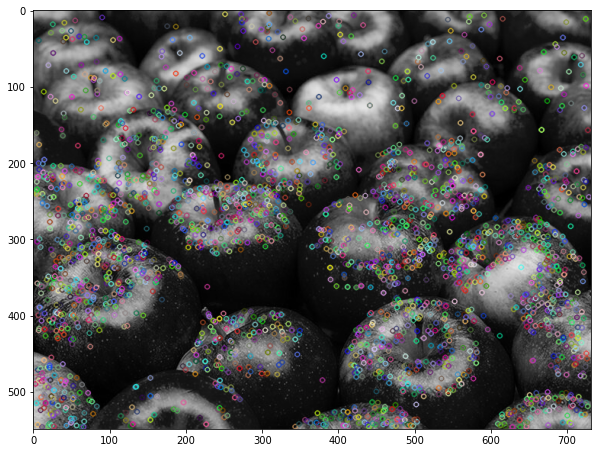

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#create sift object
sift  = cv2.xfeatures2d.SIFT_create()

def get_SIFT_features(image):
    #calculate keypoints and their orientation
    keypoints, sift_image = sift.detectAndCompute(image, None)
    return sift_image


keypoints, sift_image = sift.detectAndCompute(sample_gray_image, None)
#plot keypoints on the image
image_with_keypoints = cv2.drawKeypoints(sample_gray_image, keypoints, sample_gray_image)

#plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image_with_keypoints)
plt.show()

### Histogram of Oriented Gradients (HOG)

Un histogramme de gradient orienté (HOG) est une caractéristique utilisée en vision par ordinateur pour la détection d'objet. La technique calcule des histogrammes locaux de l'orientation du gradient sur une grille dense, c'est-à-dire sur des zones régulièrement réparties sur l'image. Cette méthode est particulièrement efficace pour la détection de personnes. Plus d'info <a href="https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html">ici</a>. Nous allons utiliser la bibliothèque <a href="https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html">skimage</a>.

In [24]:
!pip install scikit-image

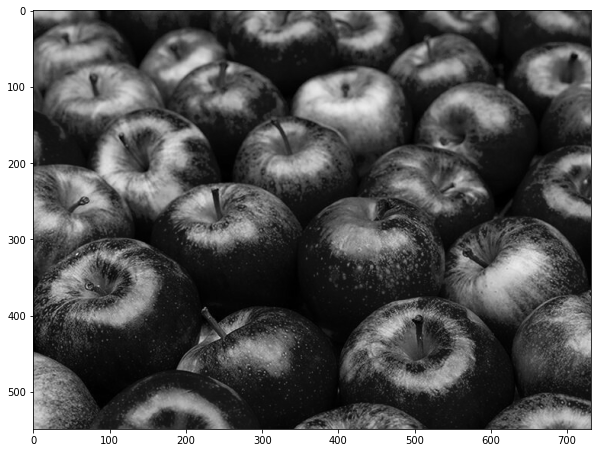

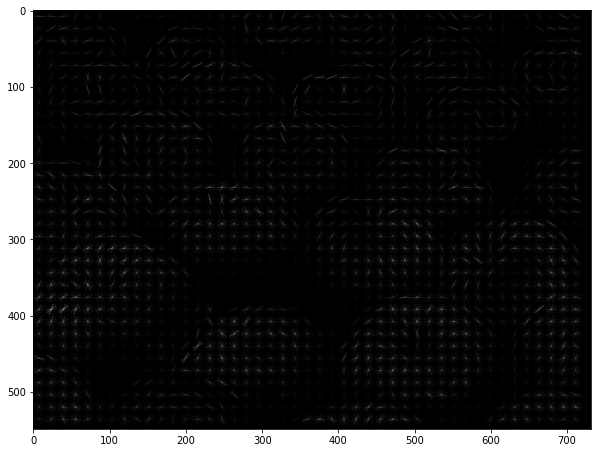

In [25]:
from skimage.feature import hog

def get_HOG_image(image):
    # Get HOG features
    hog_features, hog_image = hog(image,
                                  visualize=True,
                                  block_norm='L2-Hys',
                                  pixels_per_cell=(16, 16))
    return hog_image

plt.figure(figsize=(10, 10))
plt.imshow(sample_gray_image, cmap='gray')
plt.show()

hog_image = get_HOG_image(sample_gray_image)
plt.figure(figsize=(10, 10))
plt.imshow(hog_image, cmap='gray')
plt.show()

**Ensuite, nous créons une fonction pour prétraiter tous les images dans le dataframe Pandas.**


In [26]:
print(data['image'][0].shape)
print(data['image'][0].flatten().shape)

(560, 437, 3)
(734160,)


In [27]:
def preprocess(image):
    
    # resize image
    image = cv2.resize(image, (300, 300))
    
    # tranform image into grayscale
    image = get_gray_image(image)
    
    # we need to work with vectors so we transform the 3D matrix (height, width, channels) in 1D (a list) 
    image = image.flatten()
    
    return image

data['preprocessed_image'] = data['image'].apply(preprocess)

In [28]:
data.head() # visualisez les donnees apres pre-traitement

,path,label,image,preprocessed_image
0,data/Tobacco3482-images/Scientific/2051025161.jpg,Scientific,"[[[242, 242, 242], [255, 255, 255], [251, 251,...","[239, 252, 254, 253, 250, 255, 255, 255, 255, ..."
1,data/Tobacco3482-images/Note/87705667.jpg,Note,"[[[255, 255, 255], [252, 252, 252], [249, 249,...","[254, 251, 248, 249, 253, 255, 255, 255, 255, ..."
2,data/Tobacco3482-images/Scientific/50590463-04...,Scientific,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
3,data/Tobacco3482-images/Resume/50617225-7226.jpg,Resume,"[[[203, 203, 203], [199, 199, 199], [179, 179,...","[225, 216, 195, 201, 201, 184, 188, 188, 188, ..."
4,data/Tobacco3482-images/News/2078115137.jpg,News,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."


# 3. Preparation pour apprentissage automatique (machine learning) et apprentissage profond (deep learning)

### 3.1 Diviser les jeux de données 
Afin d'entraîner des modèles pour apprentissage automatique et évaluer la performance de ses modèles avec chaque répresentation de mots, nous allons diviser les jeux de données en : entraînement, validation et test.

Pour plus de simplicité, nous allons travailler uniquement avec des données pour entraînement et test.

In [29]:
from sklearn.model_selection import train_test_split

# Nous utilisons ici la colonne qui a été prétraitée.
X_train, X_test, y_train, y_test = train_test_split(list(data['preprocessed_image']), data['label'], test_size=0.1)
print('Train:', len(X_train), 'images', 'Test:', len(X_test), 'images')

Train: 626 images Test: 70 images


# 4. Apprentissage automatique (machine learning)

L'objectif de la catégorisation de textes est de pouvoir associer automatiquement des documents à des classes (catégories, étiquettes, index) prédéfinies. Nous nous plaçons dans le cadre de l'apprentissage automatique supervisé. 



## 4.1 Principal component analysis (PCA)

L'analyse en composantes principales (ACP ou PCA en anglais pour principal component analysis) est une méthode de la famille de l'analyse des données et plus généralement de la statistique multivariée, qui consiste à transformer des variables liées entre elles en nouvelles variables décorrélées les unes des autres. 

Ces nouvelles variables sont nommées « composantes principales », ou axes principaux. Elle réduit le nombre de variables et rend l'information moins redondante sur une donnée. 

On utilise PCA pour extraire les composants les plus pertinents dans les vecteurs des images.



In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# La normalisation des ensembles de données est une exigence 
# courante pour de nombreux estimateurs d'apprentissage automatique
# Avant d'appliquer PCA, il est nécessaire de standardiser vos données 
# (travailler avec des images signifie également travailler avec de grandes valeurs).
# Les algorithmes peuvent se comporter mal si les caractéristiques individuelles 
# ne ressemblent pas plus ou moins à des données standard normalement distribuées. 
# N'oubliez pas de normaliser vos données lorsque vous travaillez avec des images.
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

# Now, we apply PCA to reduce the vectors size
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print('PCA train data matrix shape is: ', X_train.shape)
print('PCA test data matrix shape is: ', X_test.shape)

PCA train data matrix shape is:  (626, 50)
PCA test data matrix shape is:  (70, 50)


## 4.2 Approaches de classification

### La régression logistique 
- est un algorithme de classification qui transforme sa sortie à l'aide de la fonction sigmoïde logistique pour donner une valeur de probabilité pour les classes de sortie.


La bibliothèque sklearn fournit une classe [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) qui nous permet d'entraîner et tester un modèle à partir d'un jeux de données d'entraînement.

Ensuite, nous utilisons les données d'entraînement pour entraîner le modèle.

In [31]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
classifier = LogisticRegression()

_ = classifier.fit(list(X_train), y_train) # Nous entrainons le modèle avec la méthode `fit`
print('Training finished.')

Training finished.


Après avoir entraîné notre modèle, nous pouvons faire la prediction des classes des messages du jeux de données de test.
 
## Analyse d'erreurs

Le taux d'erreur de classification donne une évaluation des performances pour toutes les classes. Mais comme les classes ne sont pas également réparties, elles peuvent ne pas être également bien modélisées. Afin d'avoir une meilleure idée des performances du classifieur, des métriques détaillées doivent être utilisées:

* [metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) fournit une analyse détaillée par classe: la précision (parmi tous les exemples classés en classe X, combien sont réellement de la classeX) et le rappel (parmi tous les exemples qui sont de la classe X, combien sont classés en classe X) et le F-Score qui est une moyenne harmonique pondérée de la précision et du rappel.

F1-score = 2 x $\frac{précision\ x\ rappel}{précision\ +\ rappel}$

 - précision : la proportion d'identifications positives était effectivement correcte.
 - rappel : la proportion de résultats positifs réels a été identifiée correctement. 


In [32]:
from sklearn.metrics import classification_report

y_pred = classifier.predict(list(X_test))

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Advertisement       0.50      1.00      0.67         3
        Email       0.57      1.00      0.73         8
         Form       0.55      0.67      0.60         9
       Letter       0.67      0.40      0.50        10
         Memo       0.50      0.58      0.54        12
         News       0.50      0.33      0.40         6
         Note       0.00      0.00      0.00         4
       Report       0.33      0.12      0.18         8
       Resume       0.00      0.00      0.00         0
   Scientific       0.12      0.10      0.11        10

     accuracy                           0.46        70
    macro avg       0.37      0.42      0.37        70
 weighted avg       0.44      0.46      0.42        70



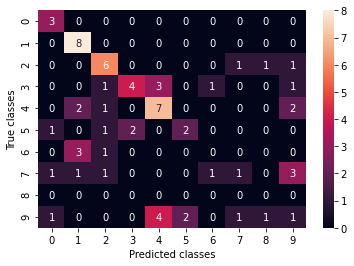

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')

plt.show()

### SVM

Les machines à vecteurs de support (en anglais support vector machine, SVM) sont un ensemble de techniques d'apprentissage supervisé destinées à résoudre des problèmes de discrimination et de régression. Ces techniques reposent sur deux idées clés : la notion de marge maximale et la notion de fonction noyau.

La bibliothèque sklearn propose un module pour utiliser de [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 

**<span style="color:red">To do</span>**:

> * Entraînez, testez et faites l'évaluation du modèle SVM linéaire. Essayez également le SVM avec différents noyaux (kernel) : `poly`, `rbf`, `sigmoid`. Pour le SVM linéaire, c'est `SVC(kernel='linear')`.
> * Rapportez le `classification_report` pour votre classificateur. Quelles classes ont les meilleurs scores ? Pourquoi ?


In [34]:
from sklearn.svm import SVC

# YOUR CODE HERE
clf = SVC(kernel = "linear")

_ = clf.fit(list(X_train), y_train)
print('Training finished.')

Training finished.


In [35]:
from sklearn.metrics import classification_report


## **<span style="color:red">To do</span>**:

Les trois représentations de base dans ce cours sont:
 - RGB
 - Gris
 - HSV
 - détection de bord Canny
 - HOG
 - SIFT

Nous pouvons utiliser une représentation toute seule ou faire de combinaisons pour ajouter caractéristiques supplémentaires qui sont possibles avec différentes représentations. Dans ce cadre, nous pouvons essayer:
 - RGB
 - Gris
 - RGB, Canny
 - Gris, HOG
 - RGB, HOG, Canny
 - SIFT, gris
 - et d'autres combinaison


> * Utilisez les autres méthodes de prétraitement (avec lemmatisation, avec racinisation, etc. `get_RGB_image, get_gray_image, get_HSV_image, get_gray_thresh_binary, get_gray_thresh_binary_inv, get_gray_thresh_trunc, get_gray_thresh_tozero, 
get_gray_thresh_tozero_inv, get_edges, get_smoothen_image, get_gaussian_blur, get_SIFT_features`) et comparez les résultats de ces trois modèles. Vous devez réécrire le code à partir de "5.1 Diviser les jeux de données" et changer la colonne de données. **Lorsque vous utilisez `get_SIFT_features`, appliquez` image = image.flatten()[:1024]`. La sortie de `get_SIFT_features` a des vecteurs de taille différente, nous prendrons un maximum de 1024 valeurs.**
> * Réécrivez la méthode de prétraitement avec différentes combinaisons, divisez l'ensemble de données, réduisez la taille avec StandardScaler et PCA entraîne les modèles de régression logistique et SVM. Vérifiez la precision (accuracy et F1-score) des résultats. 


In [36]:
def preprocess(image):
    
    # resize image
    image = cv2.resize(image, (300, 300))
    
    # YOUR CODE HERE
    image = get_SIFT_features(image)
    
    # we need to work with vectors so we transform the 3D matrix (height, width, channels) in 1D (a list) 
    image = image.flatten()[:1024]
    
    return image

data['preprocessed_image'] = data['image'].apply(preprocess)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Nous utilisons ici la colonne qui a été prétraitée.
X_train, X_test, y_train, y_test = train_test_split(list(data['preprocessed_image']), data['label'], test_size=0.1)
print('Train:', len(X_train), 'images', 'Test:', len(X_test), 'images')

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print('PCA train data matrix shape is: ', X_train.shape)
print('PCA test data matrix shape is: ', X_test.shape)

Train: 626 images Test: 70 images
PCA train data matrix shape is:  (626, 50)
PCA test data matrix shape is:  (70, 50)


In [38]:
# YOUR CODE HERE
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
classifier = LogisticRegression()

_ = classifier.fit(list(X_train), y_train) # Nous entrainons le modèle avec la méthode `fit`
print('Training finished.')

Training finished.


In [39]:
# YOUR CODE HERE
from sklearn.metrics import classification_report

y_pred = classifier.predict(list(X_test))

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Advertisement       0.00      0.00      0.00         0
        Email       0.27      0.27      0.27        11
         Form       0.18      0.17      0.17        12
       Letter       0.20      0.15      0.17        13
         Memo       0.33      0.46      0.39        13
         News       0.17      0.50      0.25         2
         Note       0.40      0.50      0.44         4
       Report       0.33      0.20      0.25         5
       Resume       0.00      0.00      0.00         1
   Scientific       0.00      0.00      0.00         9

     accuracy                           0.24        70
    macro avg       0.19      0.23      0.20        70
 weighted avg       0.22      0.24      0.23        70



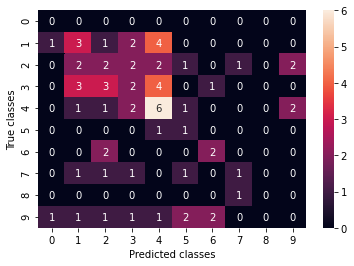

In [40]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')

plt.show()

In [41]:
# YOUR CODE HERE
from sklearn.svm import SVC

clf = SVC(kernel='linear')

_ = clf.fit(list(X_train), y_train) # Nous entrainons le modèle avec la méthode `fit`
print('Training finished.')

Training finished.


In [42]:
# YOUR CODE HERE
from sklearn.metrics import classification_report

y_pred = clf.predict(list(X_test))

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Advertisement       0.00      0.00      0.00         0
        Email       0.36      0.36      0.36        11
         Form       0.23      0.25      0.24        12
       Letter       0.33      0.23      0.27        13
         Memo       0.31      0.31      0.31        13
         News       0.33      0.50      0.40         2
         Note       0.33      0.25      0.29         4
       Report       0.14      0.20      0.17         5
       Resume       0.00      0.00      0.00         1
   Scientific       0.00      0.00      0.00         9

     accuracy                           0.24        70
    macro avg       0.20      0.21      0.20        70
 weighted avg       0.25      0.24      0.25        70



In [43]:
# YOUR CODE HERE

In [44]:
# YOUR CODE HERE

In [45]:
# YOUR CODE HERE

# 5. Apprentissage profond (deep learning)

## Classification avec des réseaux de neurones

Les réseaux de neurones peuvent être entraînés pour apprendre à la fois la représentation vectorielle des mots (au lieu de tf-idf) et comment classer les documents. Le code ci-dessous vous permet d'entraîner un classificateur des images neuronal convolutif. La plupart du code est écrit, il suffit de définir l'architecture du réseau avec les bons paramètres avant de l'entraîner:

## **<span style="color:red">To do</span>**:

> * Aller plus loin. Vérifiez [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)
> * Comment ce réseau de neurones se compare-t-il aux autres modèles? 
> * Quelle est la performance?
> * Qu'apporte le changement de paramètres dans la performance?
> * Utilisez des plongements pré-entraînés et chargez-les en tant que poids dans ce modèle (au lieu de ceux générés aléatoirement)

In [46]:
!pip install tf-nightly

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Pour appliquer des méthodes d'apprentissage en profondeur, pour les images, nous travaillerons avec deux dossiers (`train` et `test`) avec les données qui étaient déjà divisées auparavant. Nous utiliserons la méthode `image_dataset_from_directory` pour charger les images pour l'entraînement et tester le modèle.

In [48]:
image_size = (180, 180)
img_height, img_width = 180, 180
batch_size = 32

print('Training dataset:')
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Tobacco3482-images/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

print('Test dataset:')
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Tobacco3482-images/test",
    labels='inferred',
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Training dataset:
Found 626 files belonging to 10 classes.
Using 501 files for training.
Test dataset:
Found 70 files belonging to 10 classes.


Pour l'entraînement des réseaux de neurones, nous devons spécifier le nombre de classes pour la couche de prédiction.

In [55]:
CLASSES_LIST = np.unique(data['label'])
n_out = len(CLASSES_LIST)

num_classes = n_out###CORECTION ?!?

print(CLASSES_LIST, num_classes)

['Advertisement' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report'
 'Resume' 'Scientific'] 10


Réseau de neurones convolutifs pour la classification d'images (avec 3 couches convolutives):

In [57]:
from tensorflow.keras import Sequential

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # couche de prédiction
])


In [58]:
from tensorflow.keras import Sequential

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # couche de prédiction
])


Nous préparons le réseau pour l'entraînement.

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
print('Model')
model.summary()

Model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 30976)      

In [61]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(2021).prefetch(buffer_size=AUTOTUNE)

epochs = 10 # train the model for 10 epochs
history = model.fit(
  train_dataset,
  epochs=epochs
)

Epoch 1/10
16/16 [==============================] - 24s 1s/step - loss: 125.2095 - accuracy: 0.1582
Epoch 2/10
16/16 [==============================] - 21s 1s/step - loss: 2.0345 - accuracy: 0.3291
Epoch 3/10
16/16 [==============================] - 20s 1s/step - loss: 1.1985 - accuracy: 0.6051
Epoch 4/10
16/16 [==============================] - 21s 1s/step - loss: 0.2867 - accuracy: 0.9243
Epoch 5/10
16/16 [==============================] - 21s 1s/step - loss: 0.1165 - accuracy: 0.9751
Epoch 6/10
16/16 [==============================] - 20s 1s/step - loss: 0.0362 - accuracy: 0.9919
Epoch 7/10
16/16 [==============================] - 21s 1s/step - loss: 0.0036 - accuracy: 1.0000
Epoch 8/10
16/16 [==============================] - 20s 1s/step - loss: 7.9682e-04 - accuracy: 1.0000
Epoch 9/10
16/16 [==============================] - 21s 1s/step - loss: 3.3288e-04 - accuracy: 1.0000
Epoch 10/10
16/16 [==============================] - 20s 1s/step - loss: 1.2200e-04 - accuracy: 1.0000


In [62]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

y_test = []
y_pred = []

for image, y in test_dataset: # iterate in the test dataset
    y_pred += list(model.predict_classes(image)) # add the predictions of the batch to our list
    y_test += list(np.argmax(y.numpy(), axis=-1)) # add the true labels to our list

print(classification_report(y_test, y_pred, target_names=CLASSES_LIST))

               precision    recall  f1-score   support

Advertisement       1.00      0.67      0.80         3
        Email       0.67      0.77      0.71        13
         Form       0.56      0.62      0.59         8
       Letter       0.33      0.57      0.42         7
         Memo       0.56      0.64      0.60        14
         News       0.00      0.00      0.00         7
         Note       0.33      0.33      0.33         3
       Report       0.67      0.33      0.44         6
       Resume       0.17      1.00      0.29         1
   Scientific       0.75      0.38      0.50         8

     accuracy                           0.53        70
    macro avg       0.50      0.53      0.47        70
 weighted avg       0.54      0.53      0.51        70



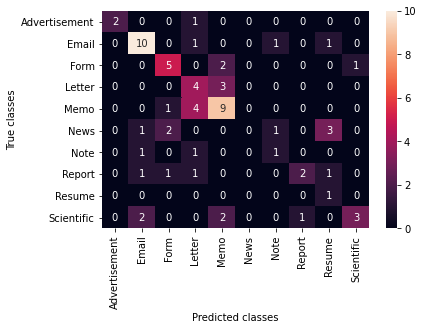

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')

plt.show()